# Getting started with downloading data in PyThalesians

In the broadest possible sense, there are three stages to any data science problem. 

* Gathering data
* Analysing data
* Presenting conculsions

Depending on the domain the type of data and analysis will of course differ. In PyThalesians, we focus on analysis of financial markets and particular making each of these steps as generic as possible, by using abstraction. Hence, you can for example, mix many different data sources using the same interface and also use many different plotting engines with minimal changes in your code. The same is true of the data analysis in PyThalesians. We've created flexible interfaces for doing backtesting, which can be used for a large number of different strategies.

In this notebook, we shall discuss how to get access to market data in PyThalesians. At present, PyThalesians supports several data sources including:

* bloomberg (via Bloomberg's Python API)
* dukascopy (FX data from DukasCopy, a retail broker)
* quandl (via Quandl's API)
* google, yahoo, fred, worldbank (using pandas-datareader API)

First we shall include the PyThalesians module on our Python path (if you have installed by pip you won't need to do this)

In [1]:
import sys

try:
    sys.path.append('E:/Remote/pythalesians')
except:
    pass

## Downloading daily market data from Bloomberg

We define a TimeSeriesRequest object, which lets us specify what time series to download with this. We need to specify several fields such as the:

* ticker (which will be used internally by PyThalesians)
* vendor ticker (different depending on the data source)
* vendor fields (eg. PX_LAST for closing prices on Bloomberg)
* data_source (eg. external data source)
* start & finish dates

In our case we are downloading S&P500, FTSE and Nikkei indices daily closing prices from Bloomberg over the past 

In [2]:
from pythalesians.market.requests.timeseriesrequest import TimeSeriesRequest
from datetime import timedelta

import datetime

tickers = ['S&P500', 'FTSE', 'Nikkei']
vendor_tickers = ['SPX Index', 'UKX Index', 'NKY Index']

time_series_request = TimeSeriesRequest(
        start_date = datetime.datetime.utcnow() - timedelta(days=180),  # start date
        finish_date = datetime.datetime.utcnow(),                       # finish date
        freq = 'daily',                                                 # daily data
        data_source = 'bloomberg',                                      # use Bloomberg as data source
        tickers = tickers,                                              # ticker (Thalesians)
        fields = ['close'],                                             # which fields to download
        vendor_tickers = vendor_tickers,                                # ticker (Bloomberg)
        vendor_fields = ['PX_LAST'],                                    # which Bloomberg fields to download
        cache_algo = 'internet_load_return')                            # how to return data

We now pass this TimeSeriesRequest object to a LightTimeSeriesFactory, which will return a pandas dataframe from the data source and will also output logger text (we can edit logging.conf to make this less verbose or to change the output of the log to disk, rather than screen, however, I've included it, so we can see which classes are being called). 

By default, PyThalesians will split up the ticker download into several chunks, using multithreading to make several calls to our data source. The number of threads can be changed in the Constants.py file (we can also specify if we would prefer to use multiprocessing as opposed to multithreading, which gets around the Python GIL. In most cases, however, the overhead of doing this is unnecessary).

In [3]:
from pythalesians.market.loaders.lighttimeseriesfactory import LightTimeSeriesFactory

ltsf = LightTimeSeriesFactory()
daily_vals = ltsf.harvest_time_series(time_series_request)

2016-03-21 13:47:17,106 - pythalesians.market.loaders.lowlevel.bbg.loaderbbgopen - INFO - Request Bloomberg data
2016-03-21 13:47:17,106 - pythalesians.market.loaders.lowlevel.bbg.loaderbbgopen - INFO - Request Bloomberg data
2016-03-21 13:47:17,106 - pythalesians.market.loaders.lowlevel.bbg.loaderbbgopen - INFO - Request Bloomberg data
2016-03-21 13:47:17,122 - pythalesians.market.loaders.lowlevel.bbg.loaderbbgopen - INFO - Starting Bloomberg session...
2016-03-21 13:47:17,122 - pythalesians.market.loaders.lowlevel.bbg.loaderbbgopen - INFO - Starting Bloomberg session...
2016-03-21 13:47:17,122 - pythalesians.market.loaders.lowlevel.bbg.loaderbbgopen - INFO - Starting Bloomberg session...
2016-03-21 13:47:17,433 - pythalesians.market.loaders.lowlevel.bbg.loaderbbgopen - INFO - Returning session...
2016-03-21 13:47:17,522 - pythalesians.market.loaders.lowlevel.bbg.loaderbbgopen - INFO - Returning session...
2016-03-21 13:47:17,607 - pythalesians.market.loaders.lowlevel.bbg.loaderbbgope

We now have the various time series in a pandas dataframe. We can rebase all the datapoints using a function in TimeSeriesCalcs

In [4]:
from pythalesians.timeseries.calcs.timeseriescalcs import TimeSeriesCalcs

tsc = TimeSeriesCalcs()

df = tsc.create_mult_index_from_prices(daily_vals)
df = df.fillna(method='ffill')

Lastly we can plot the results! We shall plot it with the PlotFactory class using PyThalesians engine (a wrapper on top of matplotlib). We can specify the properties of the plot using a GraphProperties class. The first line, forces matplotlib to give us the plot in the notebook, as opposed to a separate window. 

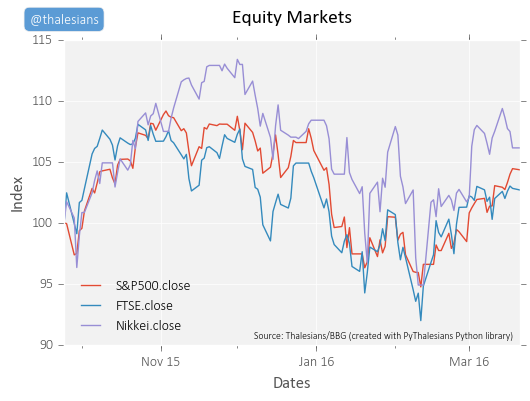

In [6]:
%matplotlib inline

from pythalesians.graphics.graphs.plotfactory import PlotFactory
from pythalesians.graphics.graphs.graphproperties import GraphProperties

gp = GraphProperties()

gp.source = 'Thalesians/BBG (created with PyThalesians Python library)'
gp.title = 'Equity Markets'
gp.scale_factor = 1
gp.display_legend = True
gp.x_title = 'Dates'
gp.y_title = 'Index'

pf = PlotFactory()
pf.plot_line_graph(df, adapter = 'pythalesians', gp = gp)